<a href="https://colab.research.google.com/github/naveen333nav/LabWorkRepo/blob/master/Traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf


TensorFlow 2.x selected.


In [0]:
import matplotlib
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation,Flatten,Dropout,Dense

In [0]:
!pip install pyyaml h5py

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os


In [0]:
# To check whether gpu allotted to you is not shared by others
#IF USED:0 MB  then all set to go
#else kill processes that using gpu by "!kill -9 -1" command  

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 



#!kill -9 -1          # for  used > 0 mb 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=bfc197f01b354e27b9368f8b2fcaefb5c87afe14b78bf12159a5f252cb114a2a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.9 GB  | Proc size: 6.6 GB
GPU RAM Free: 7082MB | Used: 529MB | Util   7% | Total 7611MB


In [0]:

# !wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
#!unzip -q GTSRB_Final_Training_Images.zip
#!ls /content/GTSRB/Final_Training/Images > train_folders.txt

In [0]:
# # load the label names
# from google.colab import files
# files.upload()
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

Saving signnames.csv to signnames.csv


In [0]:
def load_split(basepath,train_folder_list):
    train_data = []
    label_data = []

    for i in train_folder_list:
        train_path = os.path.sep.join([basepath,i,"GT-"+i+".csv"])
        rows = open(train_path).read().strip().split("\n")[1:]
        

        # loop over the rows of the CSV file
        for (j, row) in enumerate(rows):
          # check to see if we should show a status update
          if j > 0 and j % 1000 == 0:
            print("[INFO] processed {} total images".format(i))

          # split the row into components and then grab the class ID
          # and image path
         
          label_data.append(int(row.strip().split(";")[-1]))
          imagePath1 = row.strip().split(";")[0]


          # derive the full path to the image file and load it
          imagePath = os.path.sep.join([basepath,i,imagePath1])
          image = io.imread(imagePath)

          # resize the image to be 32x32 pixels, ignoring aspect ratio,
          # and then perform Contrast Limited Adaptive Histogram
          # Equalization (CLAHE)
          image = transform.resize(image, (32, 32))
          image = exposure.equalize_adapthist(image, clip_limit=0.1)

          # update the list of data and labels, respectively
          train_data.append(image)
          

        # convert the data and labels to NumPy arrays
    data = np.array(train_data)
    labels = np.array(label_data)

    # return a tuple of the data and labels
    return (data, labels)


In [0]:

train_folder_names=[]
with open("/content/train_folders.txt") as file:
  string = file.read()
  list1=string.strip().split("\n")


  
print(train_folder_names)
X_data,Y_data = load_split('/content/GTSRB/Final_Training/Images',train_folder_names)

X_data,Y_data = shuffle(X_data,Y_data)
X_data,Y_data = shuffle(X_data,Y_data)

#30% for validation
X_train,y_train = X_data[:int(len(X_data)*0.70)],Y_data[:int(len(Y_data)*0.70)]
X_valid,y_valid  =  X_data[int(len(X_data)*0.70):],Y_data[int(len(Y_data)*0.70):]



In [0]:
class TrafficSignNet:
  @staticmethod
  def build(width,height,depth,classes):
      # initialize the model along with the input shape to be
      # "channels last" and the channels dimension itself
      model = Sequential()
      inputShape = (height, width, depth)
      chanDim = -1

      # CONV => RELU => BN => POOL
      model.add(Conv2D(8, (5, 5), padding="same",
        input_shape=inputShape))
      model.add(Activation("relu"))
      model.add(BatchNormalization(axis=chanDim))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
      model.add(Conv2D(16, (3, 3), padding="same"))
      model.add(Activation("relu"))
      model.add(BatchNormalization(axis=chanDim))
      model.add(Conv2D(16, (3, 3), padding="same"))
      model.add(Activation("relu"))
      model.add(BatchNormalization(axis=chanDim))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
      model.add(Conv2D(32, (3, 3), padding="same"))
      model.add(Activation("relu"))
      model.add(BatchNormalization(axis=chanDim))
      model.add(Conv2D(32, (3, 3), padding="same"))
      model.add(Activation("relu"))
      model.add(BatchNormalization(axis=chanDim))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      # first set of FC => RELU layers
      model.add(Flatten())
      model.add(Dense(128))
      model.add(Activation("relu"))
      model.add(BatchNormalization())
      model.add(Dropout(0.5))

      # second set of FC => RELU layers
      model.add(Flatten())
      model.add(Dense(128))
      model.add(Activation("relu"))
      model.add(BatchNormalization())
      model.add(Dropout(0.5))

      # softmax classifier
      model.add(Dense(classes))
      model.add(Activation("softmax"))

      # return the constructed network architecture
      return model

In [0]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64


# scale data to the range of [0, 1]
X_train = X_train.astype("float32") / 255.0
X_valid = X_valid.astype("float32") / 255.0

# one-hot encode the training and testing labels
numLabels = len(np.unique(y_train))
y_train = to_categorical(y_train, numLabels)
y_valid1 = to_categorical(y_valid, numLabels)
# account for skew in the labeled data
classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3,
	classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# compile the model and train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(X_train,y_train, batch_size=BS),
	validation_data=(X_valid, y_valid1),
	steps_per_epoch=X_train.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)




[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 428 steps, validate on 11763 samples
Epoch 1/30
428/428 [==============================] - 21s 49ms/step - loss: 3.1369 - accuracy: 0.2201 - val_loss: 5.6371 - val_accuracy: 0.0549
Epoch 2/30
428/428 [==============================] - 14s 32ms/step - loss: 1.7371 - accuracy: 0.4630 - val_loss: 1.1178 - val_accuracy: 0.6240
Epoch 3/30
428/428 [==============================] - 14s 32ms/step - loss: 1.2863 - accuracy: 0.5857 - val_loss: 0.7443 - val_accuracy: 0.7379
Epoch 4/30
428/428 [==============================] - 14s 32ms/step - loss: 0.9907 - accuracy: 0.6746 - val_loss: 0.6958 - val_accuracy: 0.7523
Epoch 5/30
428/428 [==============================] - 14s 32ms/step - loss: 0.7991 - accuracy: 0.7368 - val_loss: 0.4489 - val_accuracy: 0.8435
Epoch 6/30
428/428 [==============================] - 14s 32ms/step - loss: 0.6651 - accuracy: 0.7819 - val_loss: 0.4461 - val_accuracy: 0.8420
Epoch 7/30


In [0]:
# # evaluate the network
from sklearn.metrics import confusion_matrix

print("[INFO] evaluating network...")
predictions = model.predict(X_valid, batch_size=BS)
print(classification_report(y_valid,
	predictions.argmax(axis=1), target_names=labelNames))

confusion_matrix(y_test,np.argmax(predictions,axis=1))






[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.88      0.97      0.92        66
                              Speed limit (30km/h)       0.98      0.96      0.97       652
                              Speed limit (50km/h)       0.86      1.00      0.92       686
                              Speed limit (60km/h)       0.96      0.94      0.95       443
                              Speed limit (70km/h)       0.97      0.99      0.98       635
                              Speed limit (80km/h)       0.98      0.84      0.90       514
                       End of speed limit (80km/h)       1.00      0.98      0.99       120
                             Speed limit (100km/h)       0.98      0.86      0.92       428
                             Speed limit (120km/h)       0.95      0.93      0.94       408
                                        No passing

array([[ 64,   2,   0, ...,   0,   0,   0],
       [  7, 629,  10, ...,   0,   0,   0],
       [  0,   0, 684, ...,   0,   0,   0],
       ...,
       [  1,   0,   0, ...,  76,   2,   3],
       [  0,   0,   0, ...,   0,  73,   0],
       [  0,   0,   0, ...,   0,   6,  64]])

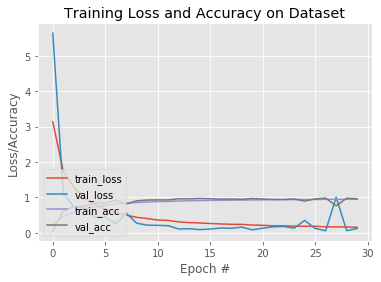

<Figure size 432x288 with 0 Axes>

In [0]:



model.save("traffic_recog.h5")

# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("save.png")

In [0]:
!ls

GTSRB  GTSRB_Final_Training_Images.zip	sample_data  signnames.csv


In [0]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
print(y_test)
print(predictions.argmax(axis=1))

(27446, 32, 32, 3) (11763, 32, 32, 3)
(27446,) (11763,)
[ 2  2 10 ...  8 16 14]
[ 2  2 10 ...  8 16 14]


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=3b25a17b52b9a506363477dfc330f20f4eb30d1e1c09dc5a640a993f0180b933
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.3 GB  | Proc size: 2.7 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


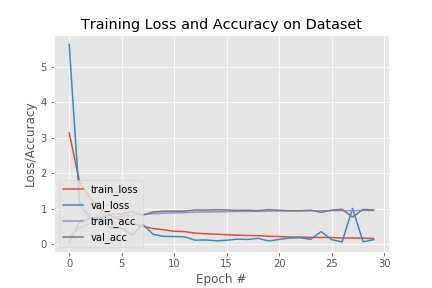

In [0]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread("/content/save.png"))

In [0]:
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip"
!unzip -q GTSRB_Online-Test-Images-Sorted.zip

--2020-02-17 09:25:44--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88234254 (84M) [application/zip]
Saving to: ‘GTSRB_Online-Test-Images-Sorted.zip’

GTSRB_Online-Test-I 100%[===================>]  84.15M  18.6MB/s    in 5.7s    

2020-02-17 09:25:50 (14.8 MB/s) - ‘GTSRB_Online-Test-Images-Sorted.zip’ saved [88234254/88234254]



In [0]:
#testing on GTSRB_Online-Test-Images-Sorted.zip dataset 
list2=[]
with open("/content/train_folders.txt") as file:
  string = file.read()
  list2=string.strip().split("\n")


  
print(list2)
X_Test_data,Y_Test_data = load_split('/content/GTSRB/Online-Test-sort',list2)

X_Test_data,Y_Test_data = shuffle(X_Test_data,Y_Test_data)
X_Test_data,Y_Test_data = shuffle(X_Test_data,Y_Test_data)

X_Test_data = X_Test_data.astype("float32") / 255.0


['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [0]:


Y_Test_pred = model.predict(X_Test_data,batch_size=BS)
cm = confusion_matrix(Y_Test_data,np.argmax(Y_Test_pred,axis=1))

accuracy = np.trace(cm)/cm.sum() 
print(accuracy)


# Since  the model trained only for  30 epochs we get 95% accuracy 
#for increased accuracy try to train model  for more epochs

0.957673641498926
